# Encoding of missing values

Given the large amount of missing values in the dataset, we think at how we can leverage this binary information across all variables to help the random forest to better use the information that may be present in the pattern of missing values.

For this purpose, binary variables of missing values are created.
Then we will use the [UMAP](https://www.youtube.com/watch?v=nq6iPZVUxZU) dimension reduction algorithm to see if we can find patterns that can be exploited.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from context import *
import visits

In [ ]:
df = visits.load()

(13533, 113)


In [ ]:
to_read = sorted(set([x for x in df.columns if x.startswith('isna')]) - set(['isna_27', 'feat_27']))

In [ ]:
%%time
# Careful, training takes X minutes
from umap import UMAP

fname = 'pipe_umap_isna.joblib'
try:
    red = joblib.load(fname)
except FileNotFoundError:
    red = UMAP(n_components=2, n_neighbors=100, min_dist=0.01, init='random', random_state=42)    
    red.fit(df[to_read])
    red.features_ = to_read
    joblib.dump(red, fname)
    
out = red.transform(df[red.features_])

read
CPU times: user 2.66 s, sys: 125 ms, total: 2.78 s
Wall time: 2.77 s


Thanks to the non linear dimension reduction algorithm, we are able to create an embedding for all visits, depending on the pattern of missing information.
We observe that the reduction algorithm seems to create clusters of various types of visit.
We have found a way to segment visits based solely on the information of missingness.
We hope that these clusters may have different levels of risk.
We will then create a categorical variable, targetting a specific cluster.
Then we will create various categorical encoding to propose this information to the random forest.

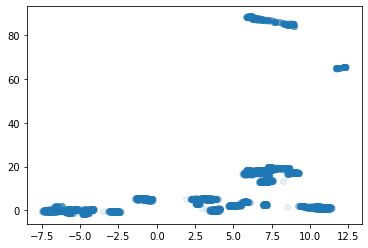

In [ ]:
fig, ax = plt.subplots()
ax.scatter(out[:,0], out[:,1], alpha=0.1);

Let's first determine the cluster by applying a DBSCAN.

In [ ]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1, min_samples=20)
labels = dbs.fit_predict(out)
len(np.unique(labels))

12

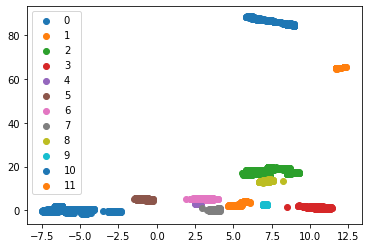

In [ ]:
fig, ax = plt.subplots()
for l in sorted(np.unique(labels)):
    mask = labels==l
    ax.scatter(out[mask,0], out[mask,1], alpha=1, label=l)
#ax.set_xlim(7.5, 25)
#ax.set_ylim(20, 40)
plt.legend();

Now that we have labelled the native cluster created by our dimension reduction, let's look at their properties in term of risk.

In [ ]:
tmp = pd.DataFrame(out, columns=['enc_0', 'enc_1'])
tmp['labels'] = labels
tmp['target'] = df['target_mild']
tmp.loc[df['feat_27'].isnull(), 'target'] = np.nan
g = tmp.groupby('labels').agg({'enc_0' : 'count', 'target' : ['count', 'mean']}).sort_values(('target', 'mean'))
g['filling_rate'] = g[('target', 'count')] / g[('enc_0', 'count')]
g

enc_0 target           filling_rate
       count  count      mean             
labels                                    
9        179    163  0.042945     0.910615
11       152    150  0.046667     0.986842
1        768    670  0.047761     0.872396
4        201    140  0.050000     0.696517
7        664    346  0.052023     0.521084
8        748    591  0.059222     0.790107
2       2412   2260  0.059735     0.936982
3       2092   1771  0.062676     0.846558
5       1114    786  0.066158     0.705566
0       3272    877  0.085519     0.268032
10       951    629  0.093800     0.661409
6        980    855  0.102924     0.872449

Looking at the rate of risky patients per group, we observe two may points:
* There is a clear hierarchy of subgroups : groups 0, 10, 6 clearly have a higher risk
* The groups also reflect an inhomogeneity with respect to the missingness of the target.
Group 0 is under represented in term of filling variable.

We will then create a simple KNN classifier to ensure an almost perfect attribution of elements to one of these categories.
Finally we will be able to create various encodings for these categories.
These encodings will then be injected in the random forest model with the hope of improving the performances.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
knn = KNeighborsClassifier(5)
X_train, X_test, y_train, y_test = train_test_split(out, labels, test_size=0.33, random_state=42)
knn.fit(X_train, y_train);

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn.predict(X_test))

1.0

In [ ]:
joblib.dump(knn, 'knn_umap_isna.joblib')

['knn_umap_isna.joblib']